In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
import seaborn as sns

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [3]:
nan_amount = train.isna().sum()
nan_amount

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
numericalCols = train.select_dtypes(include=['int64', 'float64']).columns
cols = train.columns
numericalTrain = train[numericalCols]
mean = numericalTrain.mean()
std = numericalTrain.std()
filteredNT = numericalTrain[(np.abs(numericalTrain - mean) <= 3 * std).all(axis = 1)]
interNumTrain = numericalTrain.interpolate(method='polynomial', order = 2)
nan_amount = interNumTrain.isna().sum()
nan_amount

PassengerId    0
Survived       0
Pclass         0
Age            0
SibSp          0
Parch          0
Fare           0
dtype: int64

In [5]:
categoricalCols = cols.difference(numericalCols)
categoricalTrain = train[categoricalCols]
encodedCatTrain =  categoricalTrain.apply(lambda col: LabelEncoder().fit_transform(col.astype(str)), axis=0, result_type='expand')
knn = KNNImputer(n_neighbors=2, weights='uniform')
imputedCat = knn.fit_transform(encodedCatTrain)
imputedDecodedCat = pd.DataFrame(imputedCat, columns=categoricalCols)
label_encod = {col: LabelEncoder().fit(encodedCatTrain[col]) for col in categoricalCols}
for col in categoricalCols:
    imputedDecodedCat[col] = label_encod[col].inverse_transform(imputedDecodedCat[col].astype(int))
nan_amount = imputedDecodedCat.isna().sum()
nan_amount

Cabin       0
Embarked    0
Name        0
Sex         0
Ticket      0
dtype: int64

In [6]:
filledTrain = pd.concat([interNumTrain, imputedDecodedCat], axis=1)
y_val = filledTrain.pop('Survived')

In [7]:
x_train, x_test, y_train, y_test = train_test_split(filledTrain, y_val, test_size=0.2, random_state=42)

In [8]:
model = XGBClassifier(categorical_feature='auto', eval_metric='logloss')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(cm)

/home/abog/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:28:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "categorical_feature" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8324022346368715
Confusion Matrix:
[[93 12]
 [18 56]]


In [9]:
model.save_model('models/KNN2_Order2.model')

/home/abog/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:28:12] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [10]:
sex = imputedDecodedCat.pop('Sex')


In [11]:
interNumTrain = pd.concat([interNumTrain, sex], axis=1)

In [25]:
interNumTrain['fairePclass'] = interNumTrain['Pclass'] ** interNumTrain['Fare']
interNumTrain['FamSize'] = interNumTrain['SibSp'] + interNumTrain['Parch'] + 1
interNumTrain['GenderedFaire'] = (interNumTrain['Sex'] + interNumTrain['Pclass'])*interNumTrain['Fare']


In [26]:
interNumTrain.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex,fairePclass,FamSize,GenderedFaire
0,1,0,3,22.0,1,0,7.2500,1,2878.253866,2,29.0000
1,2,1,1,38.0,1,0,71.2833,0,1.000000,2,71.2833
2,3,1,3,26.0,0,0,7.9250,0,6042.072660,1,23.7750
3,4,1,1,35.0,1,0,53.1000,0,1.000000,2,53.1000
4,5,0,3,35.0,0,0,8.0500,1,6931.482011,1,32.2000


<function matplotlib.pyplot.show(close=None, block=None)>

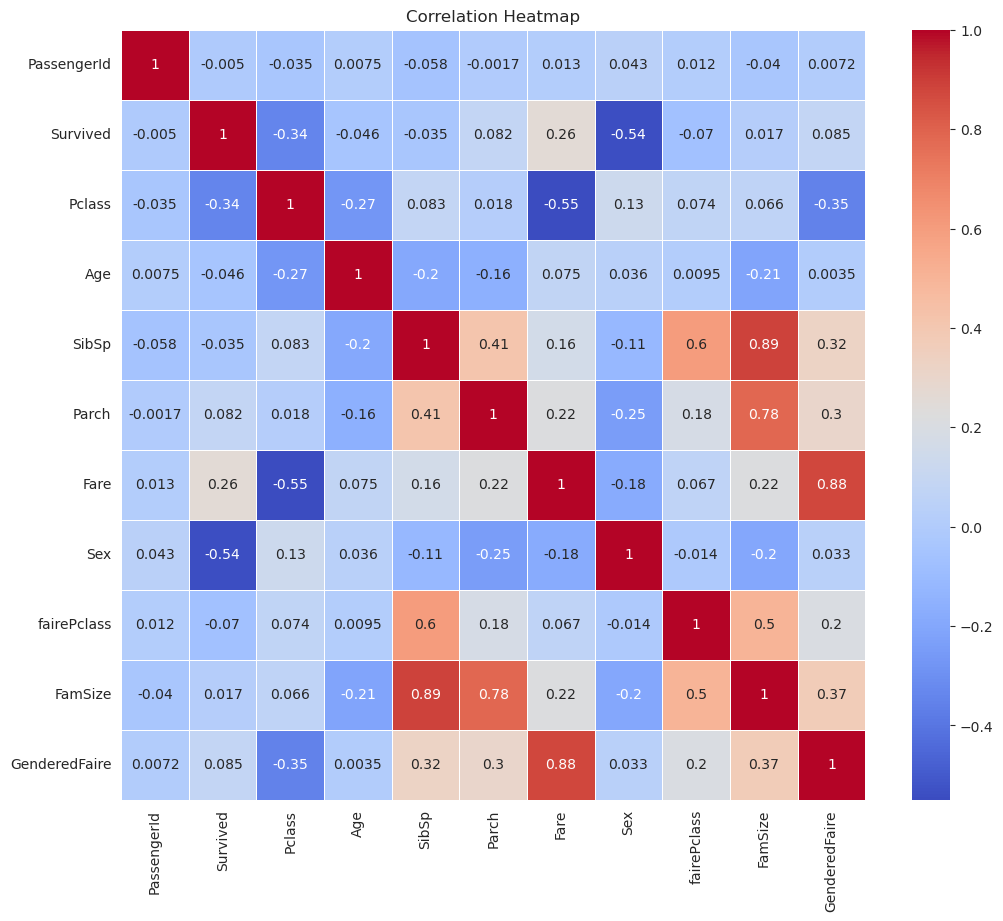

In [30]:
corr_matrix = interNumTrain.corr()
plt.figure(num = 1, figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show

In [32]:
filledTrain = pd.concat([interNumTrain, imputedDecodedCat], axis=1)
filledTrain.pop('PassengerId')
x_train, x_test, y_train, y_test = train_test_split(filledTrain, y_val, test_size=0.2, random_state=42)
model = XGBClassifier(eval_metric='logloss')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(cm)

Accuracy: 1.0
Confusion Matrix:
[[105   0]
 [  0  74]]
